# 01. PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

In [1]:
import torch
from torch import nn ## nn contains all of PyTorch's buildinig blocks and Neural Networks
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
what_are_we_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

## Data (preparing and loading)

Data can be almost anything... in machine learning

* Excel spreadsheet
* Images of any kind
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical represetantion.

To showcase this, let's create som *known* data using a linear regression formula.

We'll use a linear regression formula to make a straight line wuth *known* **parameters**.

In [3]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How to better visualize our data?

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="#1500c9", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="#00c90d", s=4, label="Test data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exists
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})


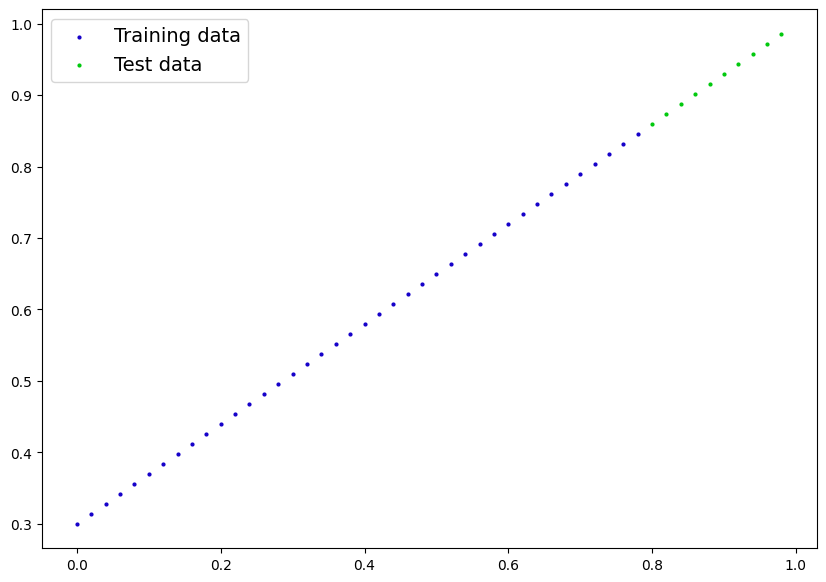

In [7]:
plot_predictions()

## Building a model

In [8]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.module
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, # <- start with a random weight
                                           requires_grad=True, # <- can this parameter be updated via gradient descent?
                                           dtype=torch.float32
                                           ))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float32
                                         ))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weight * x + self.bias # regression formula

### Pytorch model building essentials

* `torch.nn` - Contains all of the building blocks for computational graphs (a neural network can be considered a computational class)
* `torch.nn.Prameter` - What parameters should our model try and learn, often a PyTorch layer from torch.nn will set this for us
* `torch.nn.Module` - The base class for all neural network modules, if you subclass it, you should overwrite `forward()`
* `torch.optim` - This is where the optimizers in PyTorch live, they will help with gradient descent
* `def forward()` - All `nn.Module` subclasses require you to overwrite `forward()`, this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an isntance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_mode()`

To check our model's predictive value, let's check how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to pass it through the `forward()` method.



In [12]:
# Make predictions with model

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

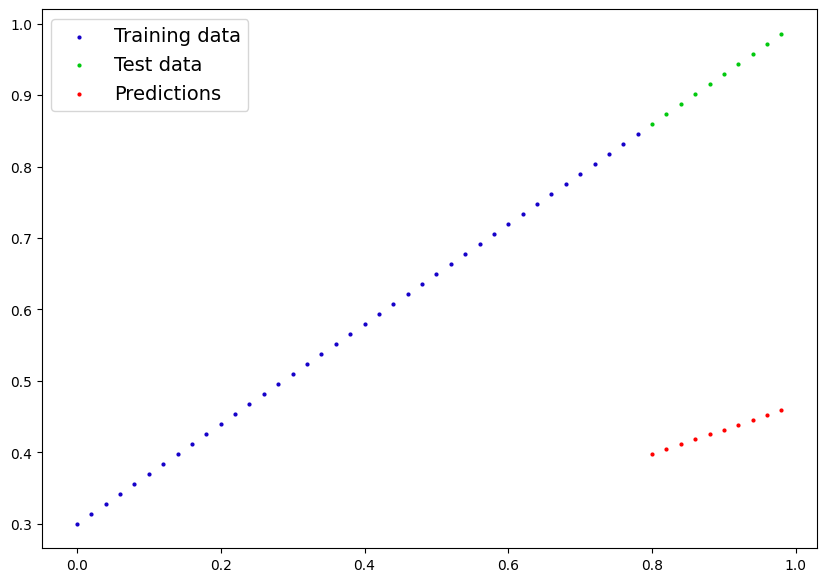

In [13]:
plot_predictions(predictions=y_preds)

## Training a model

The whole idea of training is for a model to move from some *unknown* parameters to some *known* parameters.

In other words, from a poor representation of our data, to a good representation.

One way to measure how poor or how wrong our models predictions are, we need a loss function.

* Note: Loss function may also be called cost function or criterion in different areas.

This we need to train:

* **Loss function:** A function to measure how wrong your models predictions are to the ideal outputs, so lower = better.
* **Optimizer:** Takes into account the loss of a model and adjusts to the model's parameters (e.g. weight & bias)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [14]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Create a loss function and optimizer

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01 # Learning Rate
                           )

### Create an optimization loop (training and testing loops)

A couple of things we need in a training loop:
0. Loop trhough the data and do...
1. Make predictions (this involves data moving throughout our model's `forward()` functions
2. Calculate the loss (compare predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward (move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss)
5. Optimizer step (use the optimizer to adjust our model parameters to try and improve the loss)

In [16]:
# Set a manual seed
torch.manual_seed(42)

# An epoch is one loop though the data (this is a hyperparameter beacouse we've set it ourselves)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []


### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Foward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acumulate through the loop, so we have to zero them in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different setting in the model not needed for evaluation/testing (dropout/batchnorm layers)
  with torch.inference_mode(): # turns off gradient tracking
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2- Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
      print(model_0.state_dict())
      print()

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])

Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])

Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])

Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])

Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])

Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])

Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weight', tensor([0.5116])), ('bias', tensor([0.3788]

Text(0.5, 0, 'Epoch')

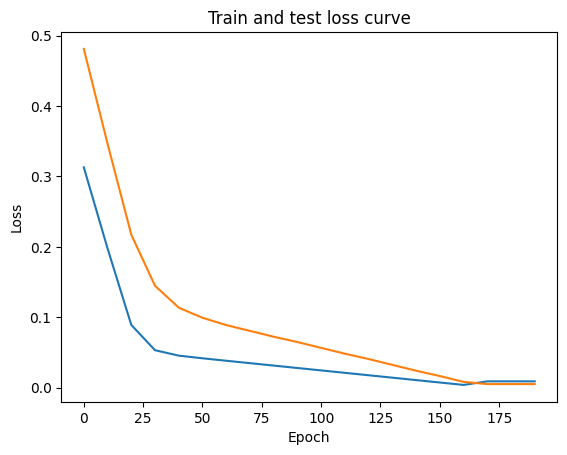

In [17]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).detach()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epoch")

### Make prediction with the trained model

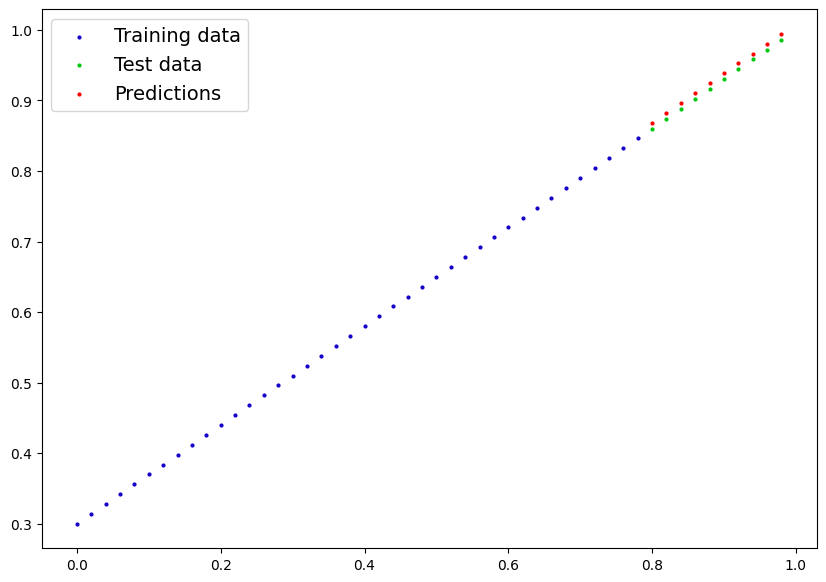

In [18]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

In [19]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

## Saving/loading a model

There are three main methods to save and load a model in PyTorch

1. `torch.save()` - Allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - Allows you to load a PyTorch object
3. `torch.nn.Module.load_state_dict()` - Allows to load a model's saved state dictionary

### Saving a model

In [20]:
# Saving our PyTorch model
# 1. Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a models save path
MODEL_NAME = Path("01_pytorch_workflow_model_0.pt")

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# 3. Save the model state_dict() (recomended by PyTorch)
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pt


In [21]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Apr 18 22:17 01_pytorch_workflow_model_0.pt


### Loading a model

Since we saved our model `state_dict()` rather than the entire model, we'll create a new instance of the model and load the saved `state_dict()` into it.

In [22]:
# Create a new instance of the model
loaded_model_0 = LinearRegressionModel()
print(loaded_model_0.state_dict())

# Load the saved state_dict()
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

print(loaded_model_0.state_dict())

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])
OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])


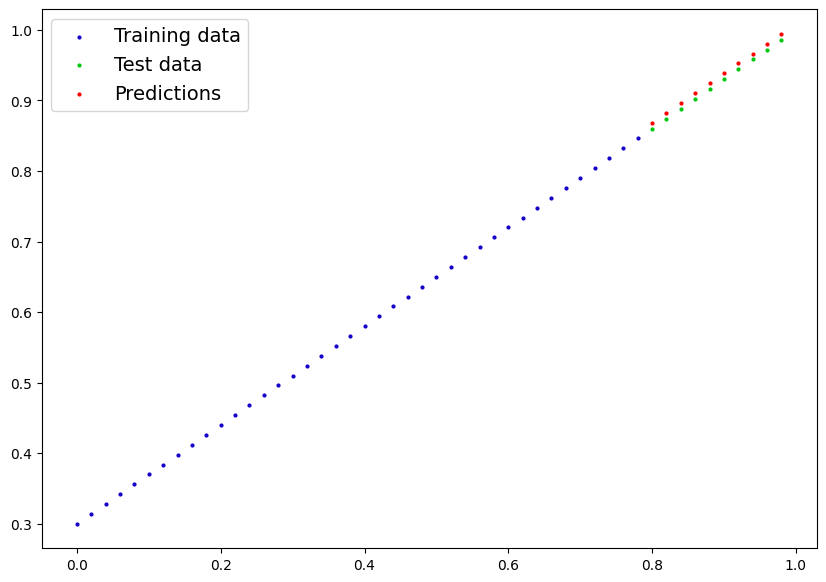

In [23]:
# Make prediction with the loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

plot_predictions(predictions=loaded_model_preds)

## Putting it all together

Let's go back through all the steps above eand see it all in one place.

### Data

In [24]:
# Create known parameters
weight = 0.13
bias = 0.12

# Create data
start = 0
end = 30
step = 0.42
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = X * weight + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.4200],
         [0.8400],
         [1.2600],
         [1.6800],
         [2.1000],
         [2.5200],
         [2.9400],
         [3.3600],
         [3.7800]]),
 tensor([[0.1200],
         [0.1746],
         [0.2292],
         [0.2838],
         [0.3384],
         [0.3930],
         [0.4476],
         [0.5022],
         [0.5568],
         [0.6114]]))

In [25]:
len(X), len(y)

(72, 72)

In [26]:
train_split = int(len(X) * 0.8)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(57, 57, 15, 15)

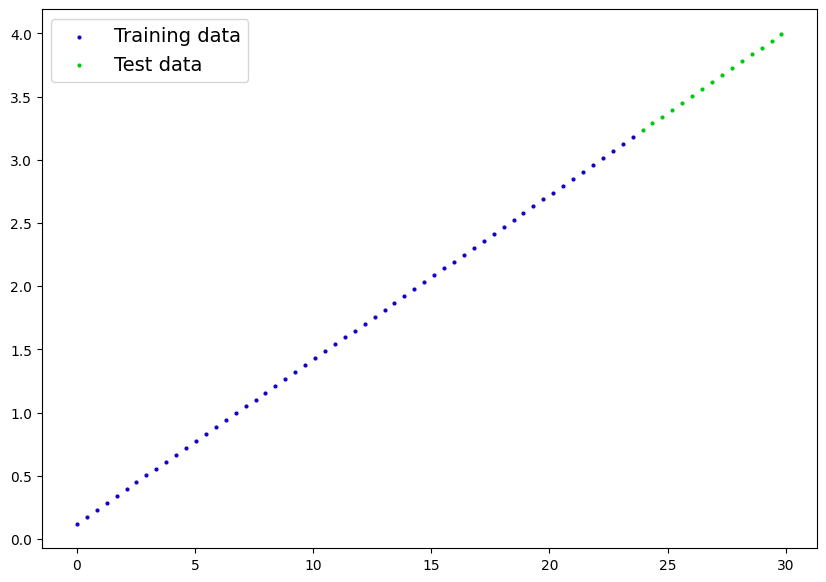

In [27]:
plot_predictions(X_train, y_train, X_test, y_test)

### Model

In [28]:
# Create a new class that subclasses nn.Module
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__() # Initializate the nn.Module

    # Create the weight/bias parameters
    self.weight = nn.Parameter(torch.randn(1,
                                           requires_grad=True,
                                           dtype=torch.float32
                                           ))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float32
                                         ))

  # Overwrite the forward method
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias

In [29]:
model = LinearRegressionModel()
model.state_dict()

OrderedDict([('weight', tensor([0.2345])), ('bias', tensor([0.2303]))])

In [30]:
weight, bias

(0.13, 0.12)

In [31]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model.to(device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

Using device: cuda


### Training

In [32]:
# Define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.0001)

In [33]:
# Create optimizing loop (train/test loop)

def optimize_loop(epochs=100,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test,
                  save=5):

  epoch_count = []
  train_loss = []
  test_loss_values = []

  for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Make predictions
    y_pred = model(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()

    if epoch % save == 0:

      with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

      epoch_count.append(epoch)
      train_loss.append(loss)
      test_loss_values.append(test_loss)

      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
      print(model.state_dict())
      print()

  # Plot the loss curves
  plt.plot(epoch_count, np.array(torch.tensor(train_loss).detach()), label="Train loss")
  plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).cpu()), label="Test loss")
  plt.title("Train and test loss curve")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")

Epoch: 0 | Loss: 2.313431978225708 | Test loss: 7.909907341003418
OrderedDict([('weight', tensor([0.2303], device='cuda:0')), ('bias', tensor([0.2301], device='cuda:0'))])

Epoch: 5 | Loss: 1.581775426864624 | Test loss: 5.346670150756836
OrderedDict([('weight', tensor([0.2118], device='cuda:0')), ('bias', tensor([0.2289], device='cuda:0'))])

Epoch: 10 | Loss: 1.0817893743515015 | Test loss: 3.6055283546447754
OrderedDict([('weight', tensor([0.1965], device='cuda:0')), ('bias', tensor([0.2279], device='cuda:0'))])

Epoch: 15 | Loss: 0.7401178479194641 | Test loss: 2.4243552684783936
OrderedDict([('weight', tensor([0.1838], device='cuda:0')), ('bias', tensor([0.2270], device='cuda:0'))])

Epoch: 20 | Loss: 0.5066324472427368 | Test loss: 1.6243418455123901
OrderedDict([('weight', tensor([0.1734], device='cuda:0')), ('bias', tensor([0.2264], device='cuda:0'))])

Epoch: 25 | Loss: 0.34707701206207275 | Test loss: 1.0835555791854858
OrderedDict([('weight', tensor([0.1647], device='cuda:0'

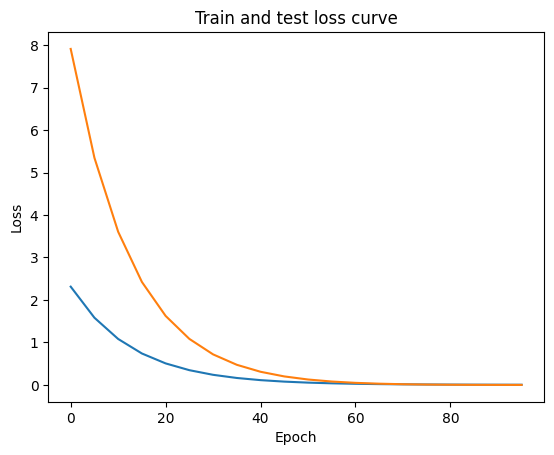

In [34]:
optimize_loop(epochs=100)

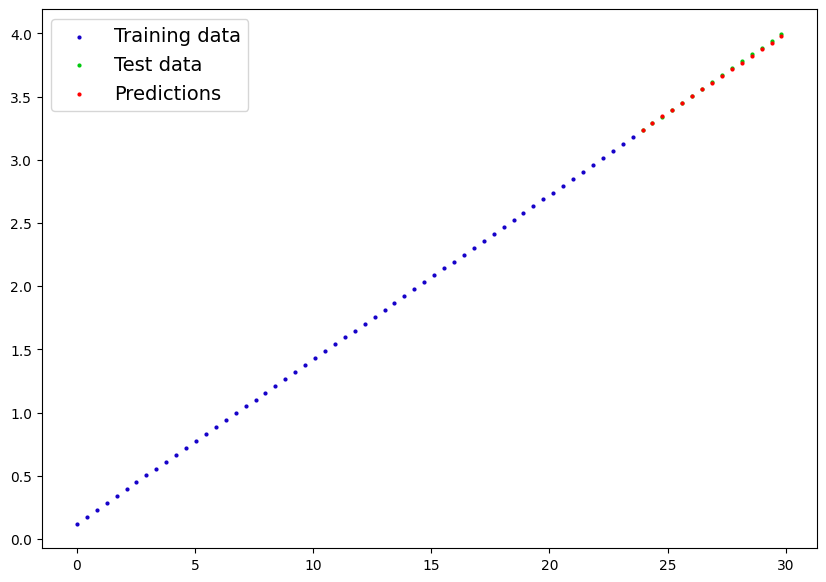

In [35]:
with torch.inference_mode():
  y_preds_new = model(X_test)

plot_predictions(X_train.clone().detach().cpu(),
                 y_train.clone().detach().cpu(),
                 X_test.clone().detach().cpu(),
                 y_test.clone().detach().cpu(),
                 predictions=y_preds_new.clone().detach().cpu())